Sometimes in regression we don't want to estimate the mean, but the upper/lower bound of your dataset, or some quantile value. This is where quantile regression comes to play. The idea is that rather than estimating the usual conditional mean via MSE or MAE, we will penalize it more heavily if the residual goes below certain threshold. Thus the prediction after training will gravitate toward that threshold value. 

In [37]:
import gpustat
gpustat.print_gpustat()
import os
os.environ['CUDA_VISIBLE_DEVICES']='2'
import random
random.seed(0)
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.optimizers import SGD
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten, Concatenate, Lambda
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras import backend as K
import seaborn as sns
sns.set(style="white", color_codes=True)
from sklearn.ensemble import GradientBoostingRegressor

gpu-4-culture-plate-sm  Fri Jul 26 14:20:34 2019
[0] GeForce GTX 1080 | 26'C,   0 % |     0 /  8114 MB |
[1] GeForce GTX 1080 | 55'C,  41 % |  5333 /  8114 MB | thong(5323M)
[2] GeForce GTX 1080 | 34'C,   0 % |  7781 /  8114 MB | thong(7771M)
[3] GeForce GTX 1080 | 25'C,   0 % |  7561 /  8114 MB | thong(7551M)
[4] GeForce GTX 1080 | 55'C,  43 % |  1427 /  8114 MB | azlokapa(1417M)
[5] GeForce GTX 1080 | 63'C,  48 % |  1501 /  8114 MB | azlokapa(1491M)
[6] GeForce GTX 1080 | 27'C,   0 % |  3817 /  8114 MB | thong(3807M)
[7] GeForce GTX 1080 | 26'C,   0 % |     0 /  8114 MB |


/nfshome/thong/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/nfshome/thong/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Number of data points:  2000


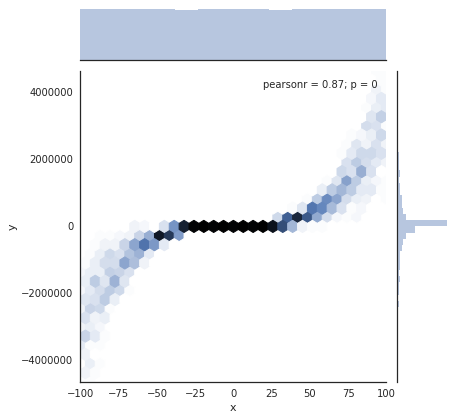

In [90]:
x = np.arange(-100,100, step=0.1)
y = 3+3*x*x*x + np.random.normal(0, np.absolute(np.power(x,3)))
yval = 3+3*x*x*x + np.random.normal(0, np.absolute(np.power(x,3)))
data = pd.DataFrame({'x':x, 'y':y, 'yval': yval})
sns.jointplot(x="x", y="y", data=data, kind='hex')

# Shuffle the dataset for training
idx = np.arange(len(x))
np.random.shuffle(idx)
x_train = x[idx]
y_train = y[idx]
y_trainval = yval[idx]
print("Number of data points: ", len(x))

In [91]:
def quantile_loss(target, pred):
    alpha = 0.99
    err = target - pred
    return K.tf.where(err>=0, alpha*err, (alpha-1)*err)

inputs = Input(shape=(1,))
hidden = Dense(1000, activation='relu')(inputs)
hidden = Dense(1000, activation='relu')(hidden)
hidden = Dense(1000, activation='relu')(hidden)
output = Dense(1)(hidden)
model = Model(inputs, output)
model.compile(loss=quantile_loss, optimizer='adam')
model.summary()

model.fit(x_train,y_train,  epochs=100, batch_size=1000, verbose=1, 
          callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
          validation_data=(x,yval))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 1)                 0         
_________________________________________________________________
dense_59 (Dense)             (None, 1000)              2000      
_________________________________________________________________
dense_60 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_61 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 1001      
Total params: 2,005,001
Trainable params: 2,005,001
Non-trainable params: 0
_________________________________________________________________
Train on 2000 samples, validate on 2000 samples
Epoch 1/100
2000/2000 [==============================] - 1s 289us/step - loss: 38189

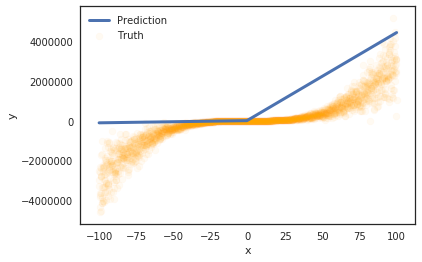

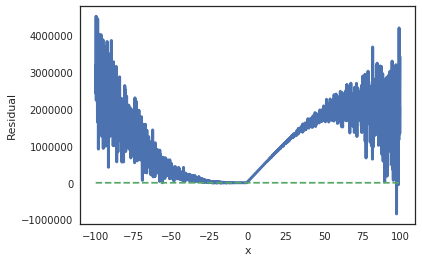

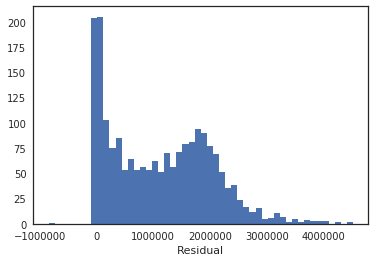

In [92]:
yhat = model.predict(x.reshape(-1,1))
plt.plot(x,yhat, linewidth=3, label='Prediction')
plt.scatter(x,yval, color='orange', label='Truth', alpha=0.05)
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure()
res_y = yhat.flatten()-yval
plt.plot(x, res_y, linewidth=3)
plt.plot(x,0*x, '--')
plt.xlabel('x')
plt.ylabel('Residual')
plt.show()

plt.figure()
plt.hist(res_y, bins=50)
plt.xlabel("Residual")
plt.show()

This was caused by not having enough statistics. Let's try again with better statistics

/nfshome/thong/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/nfshome/thong/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Number of data points:  200000


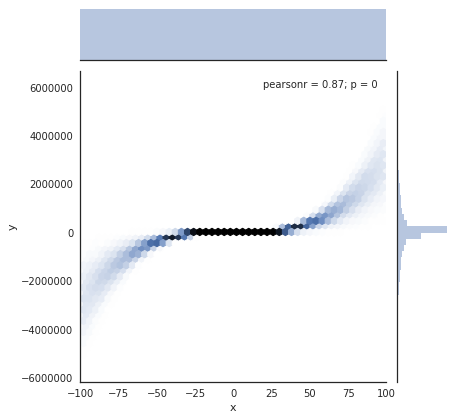

In [93]:
x = np.arange(-100,100, step=0.001)
y = 3+3*x*x*x + np.random.normal(0, np.absolute(np.power(x,3)))
yval = 3+3*x*x*x + np.random.normal(0, np.absolute(np.power(x,3)))
data = pd.DataFrame({'x':x, 'y':y, 'yval': yval})
sns.jointplot(x="x", y="y", data=data, kind='hex')

# Shuffle the dataset for training
idx = np.arange(len(x))
np.random.shuffle(idx)
x_train = x[idx]
y_train = y[idx]
y_trainval = yval[idx]
print("Number of data points: ", len(x))

In [94]:
def quantile_loss(target, pred):
    alpha = 0.99
    err = target - pred
    return K.tf.where(err>=0, alpha*err, (alpha-1)*err)

inputs = Input(shape=(1,))
hidden = Dense(1000, activation='relu')(inputs)
hidden = Dense(1000, activation='relu')(hidden)
hidden = Dense(1000, activation='relu')(hidden)
output = Dense(1)(hidden)
model = Model(inputs, output)
model.compile(loss=quantile_loss, optimizer='adam')
model.summary()

model.fit(x_train,y_train,  epochs=100, batch_size=1000, verbose=1, 
          callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
          validation_data=(x,yval))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 1)                 0         
_________________________________________________________________
dense_63 (Dense)             (None, 1000)              2000      
_________________________________________________________________
dense_64 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_65 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 1001      
Total params: 2,005,001
Trainable params: 2,005,001
Non-trainable params: 0
_________________________________________________________________
Train on 200000 samples, validate on 200000 samples
Epoch 1/100
200000/200000 [==============================] - 2s 11us/step - loss

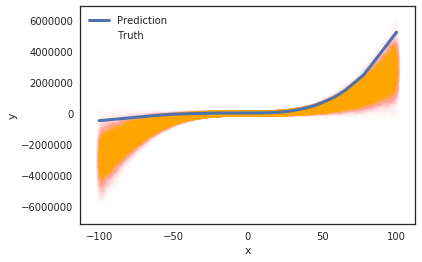

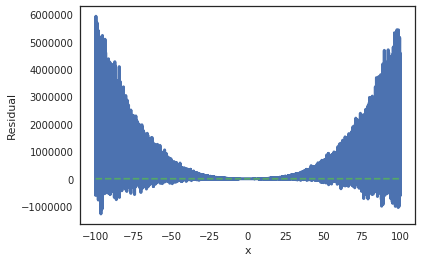

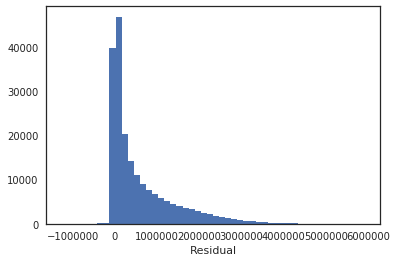

In [96]:
yhat = model.predict(x.reshape(-1,1))
plt.plot(x,yhat, linewidth=3, label='Prediction')
plt.scatter(x,yval, color='orange', label='Truth', alpha=0.005)
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure()
res_y = yhat.flatten()-yval
plt.plot(x, res_y, linewidth=3)
plt.plot(x,0*x, '--')
plt.xlabel('x')
plt.ylabel('Residual')
plt.show()

plt.figure()
plt.hist(res_y, bins=50)
plt.xlabel("Residual")
plt.show()

Much better!